In [1]:
import time
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn import decomposition
import matplotlib.pyplot as plt
from IPython.display import clear_output



#qiskit libraries
from qiskit import Aer
from qiskit.primitives import Sampler
from qiskit import execute
from qiskit import transpile, assemble
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider
#qiskit circuit libraries
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap,PauliFeatureMap
from qiskit.circuit.library import RealAmplitudes

#qiskit optimizer libraries
from qiskit.algorithms.optimizers import SPSA,COBYLA

#qiskit algorithms
from qiskit_machine_learning.algorithms import VQC,QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit.utils import algorithm_globals


# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
pca = decomposition.PCA(n_components=4)
pca.fit(X)
X = pca.transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the feature data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [2]:
N = X.shape[1]
print(N)

4


In [3]:
# Create an instance of the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=5000, random_state=42)

# Train the MLP classifier
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(50,), max_iter=5000, random_state=42)

In [4]:
# Make predictions with MLP classifier
y_pred_mlp = mlp.predict(X_test)

# Calculate accuracy, F1 score, precision, and recall for MLP classifier
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')
precision_mlp = precision_score(y_test, y_pred_mlp, average='weighted')
recall_mlp = recall_score(y_test, y_pred_mlp, average='weighted')

print("MLP Classifier Accuracy:", accuracy_mlp)
print("MLP Classifier F1 Score:", f1_mlp)
print("MLP Classifier Precision:", precision_mlp)
print("MLP Classifier Recall:", recall_mlp)

MLP Classifier Accuracy: 1.0
MLP Classifier F1 Score: 1.0
MLP Classifier Precision: 1.0
MLP Classifier Recall: 1.0


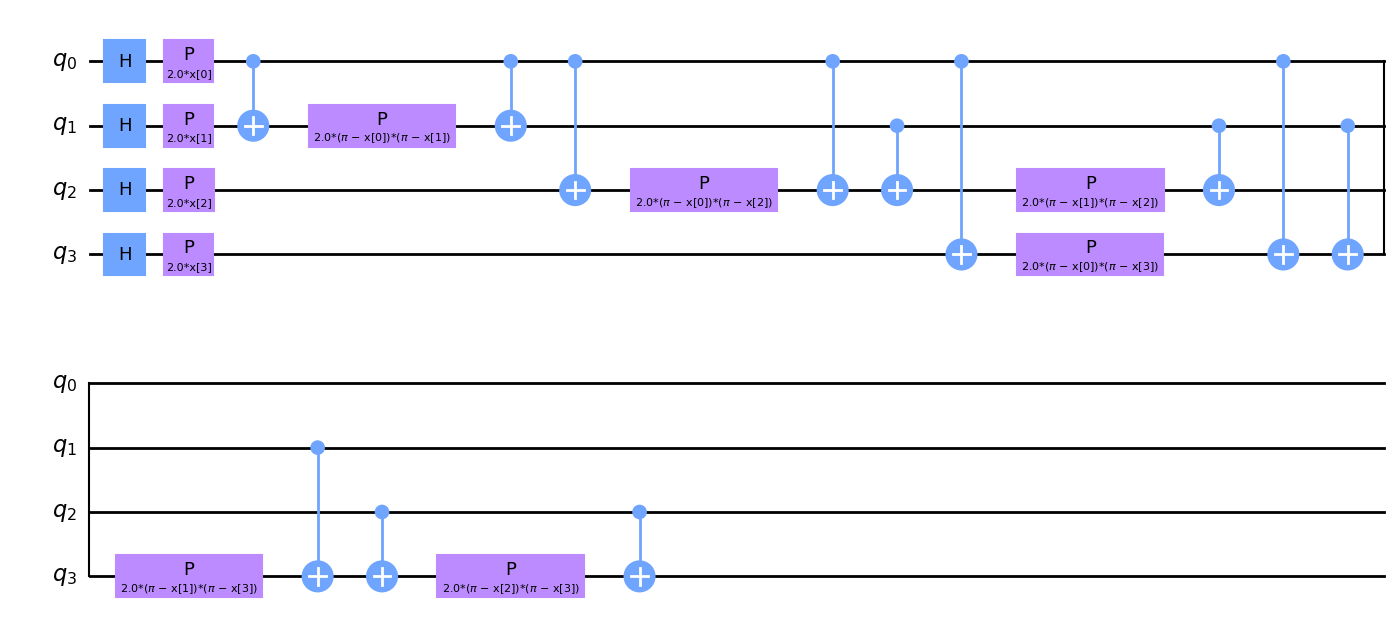

In [5]:
# Define the quantum feature map
feature_map = ZZFeatureMap(feature_dimension=N, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

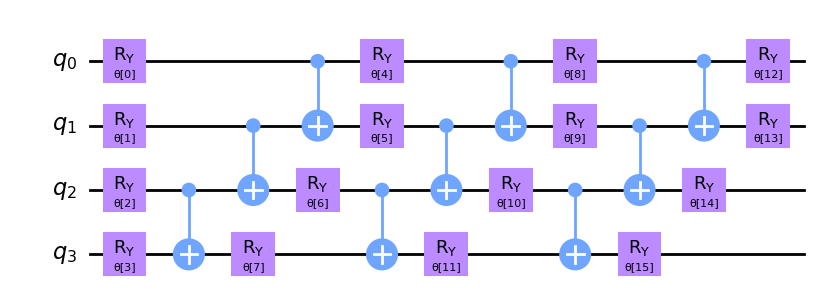

In [6]:
# Define the quantum kernel
ansatz = RealAmplitudes(num_qubits=N, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

In [7]:
optimizer = COBYLA(maxiter=100)

sampler = Sampler()

In [8]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    


In [9]:
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
    sampler=sampler
)


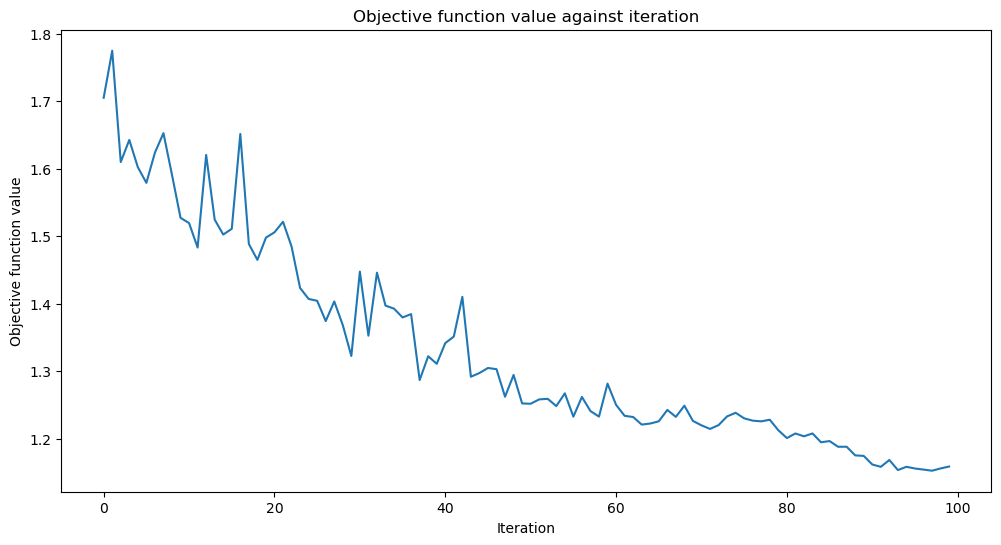

Training time: 792 seconds


In [10]:
objective_func_vals = []

start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [11]:
# Make predictions with VQC
y_pred_vqc = vqc.predict(X_test)

# Calculate accuracy, F1 score, precision, and recall for VQC
accuracy_vqc = accuracy_score(y_test, y_pred_vqc)
f1_vqc = f1_score(y_test, y_pred_vqc, average='weighted')
precision_vqc = precision_score(y_test, y_pred_vqc, average='weighted')
recall_vqc = recall_score(y_test, y_pred_vqc, average='weighted')

train_score = vqc.score(X_train, y_train)
test_score = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset: {train_score:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score:.2f}")

print("VQC Accuracy:", accuracy_vqc)
print("VQC F1 Score:", f1_vqc)
print("VQC Precision:", precision_vqc)
print("VQC Recall:", recall_vqc)

print("VQC training score:", train_score)
print("VQC test score:", test_score)

Quantum VQC on the training dataset: 0.73
Quantum VQC on the test dataset:     0.67
VQC Accuracy: 0.6666666666666666
VQC F1 Score: 0.6787330316742081
VQC Precision: 0.7935574229691877
VQC Recall: 0.6666666666666666
VQC training score: 0.7333333333333333
VQC test score: 0.6666666666666666


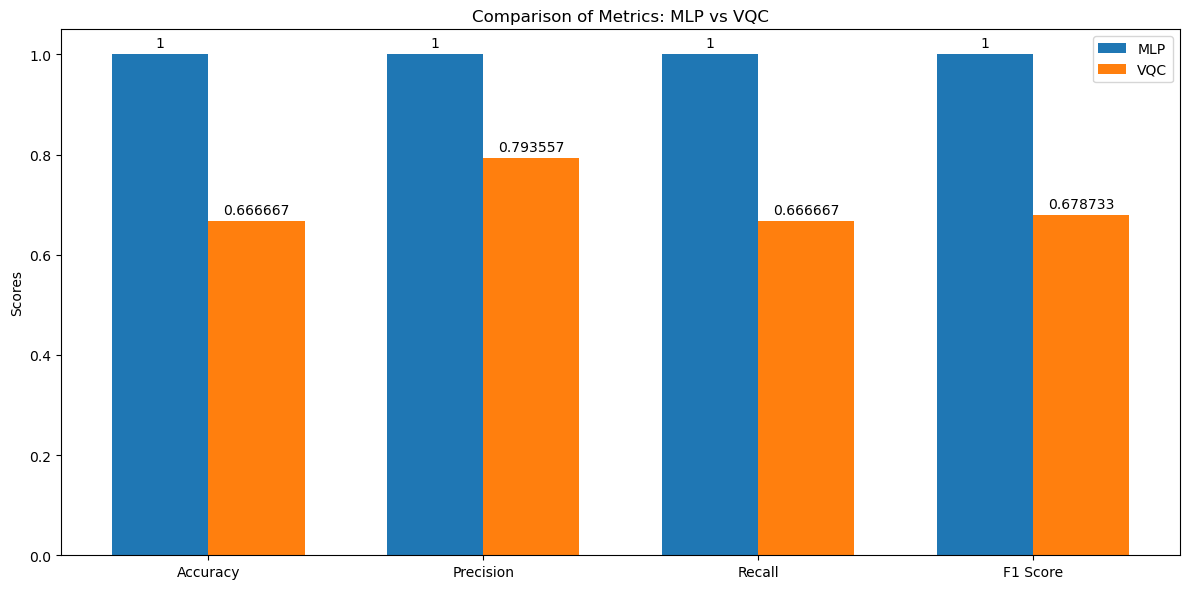

In [12]:
# Bar chart
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
svm_scores = [accuracy_mlp, precision_mlp, recall_mlp, f1_mlp]
qsvm_scores = [accuracy_vqc, precision_vqc, recall_vqc, f1_vqc]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, svm_scores, width, label='MLP')
rects2 = ax.bar(x + width/2, qsvm_scores, width, label='VQC')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics: MLP vs VQC')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()